In [22]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Download the dataset from its original source by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [23]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-08-02 19:19:39--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.51.99.68, 2600:1413:1:597::317f, 2600:1413:1:5a0::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.51.99.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   216MB/s    in 3.5s    

2023-08-02 19:19:43 (223 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [24]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [25]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  training_dir = os.path.join(root_dir, "training")
  validation_dir = os.path.join(root_dir, "validation")
  training_cats_dir = os.path.join(training_dir, "cats")
  training_dogs_dir = os.path.join(training_dir, "dogs")
  validation_cats_dir = os.path.join(validation_dir, "cats")
  validation_dogs_dir = os.path.join(validation_dir, "dogs")
  os.makedirs(training_cats_dir, exist_ok=True)
  os.makedirs(training_dogs_dir, exist_ok=True)
  os.makedirs(validation_cats_dir, exist_ok=True)
  os.makedirs(validation_dogs_dir, exist_ok=True)


  ### END CODE HERE


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [26]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


In [27]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """
  ### START CODE HERE
  files  = os.listdir(SOURCE_DIR)
  random.shuffle(files)
  split_index = int(SPLIT_SIZE * len(files))
  training_files = files[:split_index]
  validation_files = files[split_index:]

  for file in training_files:
    file_path = os.path.join(SOURCE_DIR, file)
    if os.path.getsize(file_path) > 0:
      shutil.copy(file_path, os.path.join(TRAINING_DIR, file))
    else:
      print(f"{file} is zero length, so ignoring.")

  for file in validation_files:
    file_path = os.path.join(SOURCE_DIR, file)
    if os.path.getsize(file_path) > 0:
      shutil.copy(file_path, os.path.join(VALIDATION_DIR, file))
    else:
      print(f"{file} is zero length, so ignoring.")


  ### END CODE HERE

In [28]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise use a `target_size` of (150, 150)**.

In [50]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=90,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     shear_range=0.2,
                                     zoom_range=0.4,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=90,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     shear_range=0.2,
                                     zoom_range=0.4,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [45]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` you defined in the previous exercise, which should also be compatible with the output of your network. You can tell if they aren't compatible if you get an error during training.

**Note that you should use at least 3 convolution layers to achieve the desired performance.**

In [51]:
# grader-required-cell
from tensorflow.keras.optimizers import RMSprop

def create_model():

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
  model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [52]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 310/1125 [=======>......................] - ETA: 31s - loss: 0.6843 - accuracy: 0.5642

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 52s 44ms/step - loss: 0.6059 - accuracy: 0.6609 - val_loss: 0.5175 - val_accuracy: 0.7592
Epoch 2/15
1125/1125 [==============================] - 48s 43ms/step - loss: 0.4533 - accuracy: 0.7890 - val_loss: 0.5518 - val_accuracy: 0.7564
Epoch 3/15
1125/1125 [==============================] - 48s 43ms/step - loss: 0.3637 - accuracy: 0.8404 - val_loss: 0.3650 - val_accuracy: 0.8352
Epoch 4/15
1125/1125 [==============================] - 46s 41ms/step - loss: 0.2936 - accuracy: 0.8759 - val_loss: 0.3377 - val_accuracy: 0.8456
Epoch 5/15
1125/1125 [==============================] - 49s 44ms/step - loss: 0.2443 - accuracy: 0.8994 - val_loss: 0.3477 - val_accuracy: 0.8672
Epoch 6/15
1125/1125 [==============================] - 48s 43ms/step - loss: 0.2056 - accuracy: 0.9182 - val_loss: 0.3797 - val_accuracy: 0.8676
Epoch 7/15
1125/1125 [==============================] - 49s 44ms/step - loss: 0.1698 - accuracy: 0.9324 - val_loss: 0.3427 - val_accura

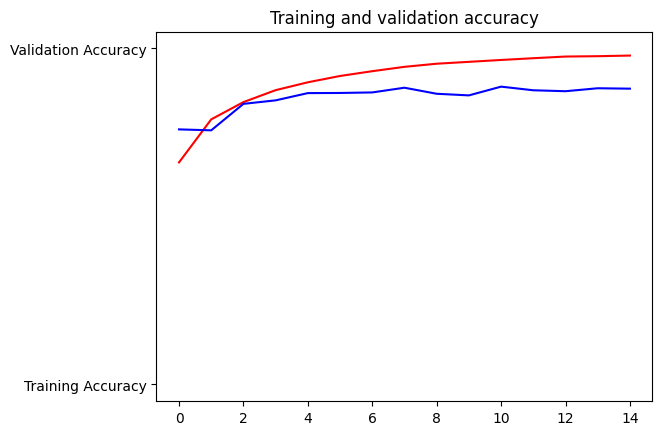

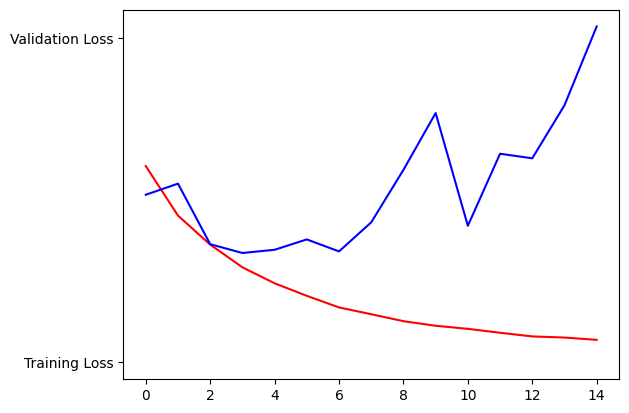

In [53]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()